# Hum Engagement Time Machine
## Final Model Using k-Means Clustered Labels and MLP-Based Classification

## This notebook will go through the MLP construction and classification process.

### MLP for Binary Classification (First 16 Events)

In [1]:
# load in data file from local device (training_labels.csv)
from google.colab import files
uploaded = files.upload()

Saving training_labels.csv to training_labels.csv


In [3]:
# import relevant packages
import pandas as pd
import numpy as np
import io

# read in and upload training labels produced from clustering
labels = pd.read_csv(io.BytesIO(uploaded['training_labels.csv']))
labels = labels.to_numpy().T[0]
labels

array([1, 1, 1, ..., 1, 0, 1])

In [5]:
# load in data file from local device (reached_16_first_16.csv)
from google.colab import files
uploaded = files.upload()

Saving reached_16_first_16.csv to reached_16_first_16.csv


In [6]:
# read in uploaded csv data to a pandas dataframe
df = pd.read_csv(io.BytesIO(uploaded['reached_16_first_16.csv']))
df.sort_values(by = 'PROFILE_ID', inplace = True)
df

,Unnamed: 0,PROFILE_ID,REACHED_16_EVENTS,REACHED_80_EVENTS,RECENT_LAST_EVENT,EVENT_CYCLES_F16,DISTINCT_ARTICLES_F16,PERCENT_GOOGLE_ARTICLES_F16,PERCENT_ARTICLE_CONTENT_F16,AVERAGE_CONTENT_SCORE_F16,DAYS_TO_16_EVENTS,EVENTS,FIRST_EVENT_TIME,EVENT_TIME_16,DISTINCT_DAYS_F16
11,11,--0p74IB28LFeUkXSg6b,1,0,0,2,2,0.000000,1.0,0.0,133.0,16,2022-08-30 14:30:38.171966,2023-01-10 16:43:55.720219,2
29,29,--6dYIIB8Tq1gs32cnxN,1,0,0,1,1,1.000000,1.0,0.0,7.0,16,2022-08-02 22:11:48.120981,2022-08-09 16:19:25.990118,4
2,2,--7CGYYBRkWobPtw2Qjb,1,0,1,3,1,1.000000,1.0,0.0,27.0,24,2023-02-04 00:10:45.911994,2023-03-03 04:29:56.373198,3
7,7,--7egIIBGoM3uBpFKICG,1,0,0,1,4,1.000000,1.0,0.0,5.0,63,2022-08-09 04:30:20.132357,2022-08-14 21:53:19.151456,3
28,28,--7xtoIBGoM3uBpFf0FV,1,0,0,3,2,0.000000,1.0,0.0,103.0,16,2022-08-19 16:30:57.064488,2022-11-30 19:41:43.155668,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139000,2437840,zzlKjIIBGoM3uBpFBagQ,1,0,1,3,3,0.666667,1.0,0.0,133.0,40,2022-08-11 09:43:58.953482,2022-12-22 09:37:29.844389,4
139077,2438029,zzpjDYQBEEdskq5qGMuW,1,0,0,2,1,0.000000,1.0,0.0,17.0,28,2022-10-25 04:25:09.614383,2022-11-11 13:42:32.907519,7
139015,2437855,zzrPDIQBEEdskq5qZRER,1,0,0,4,3,0.333333,1.0,0.0,129.0,16,2022-10-25 01:43:50.150416,2023-03-03 07:59:42.533219,4
139082,2438034,zzsQPYQBwWEOklUHCNVJ,1,0,0,1,0,0.000000,0.0,0.0,2.0,56,2022-11-03 10:36:12.009305,2022-11-05 03:42:30.198338,3


In [7]:
# create time-based features
df = df[df['EVENTS'] <= 100]
# events per cycle
df['EpC'] = 16/df['EVENT_CYCLES_F16']
# articles per event
df['ApE'] = df['DISTINCT_ARTICLES_F16']/16
# event density
df['ED'] = 16/df['DISTINCT_DAYS_F16']

# extract relevant columns of the data and their corresponding labels
#data = df[['EpC','ApE','PERCENT_GOOGLE_ARTICLES_F16','PERCENT_ARTICLE_CONTENT_F16','ED']]
data = df[['ApE','PERCENT_GOOGLE_ARTICLES_F16','PERCENT_ARTICLE_CONTENT_F16','ED']]
features = data.columns
data

<ipython-input-7-4308882e8af6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EpC'] = 16/df['EVENT_CYCLES_F16']
<ipython-input-7-4308882e8af6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ApE'] = df['DISTINCT_ARTICLES_F16']/16
<ipython-input-7-4308882e8af6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,ApE,PERCENT_GOOGLE_ARTICLES_F16,PERCENT_ARTICLE_CONTENT_F16,ED
11,0.1250,0.000000,1.0,8.000000
29,0.0625,1.000000,1.0,4.000000
2,0.0625,1.000000,1.0,5.333333
7,0.2500,1.000000,1.0,5.333333
28,0.1250,0.000000,1.0,4.000000
...,...,...,...,...
139000,0.1875,0.666667,1.0,4.000000
139077,0.0625,0.000000,1.0,2.285714
139015,0.1875,0.333333,1.0,4.000000
139082,0.0000,0.000000,0.0,5.333333


In [8]:
from sklearn.preprocessing import StandardScaler

# define standard scaler
scaler = StandardScaler()
  
# transform data
data = scaler.fit_transform(data)

data

array([[-0.2372927 , -0.77395678,  0.56527274,  0.2351622 ],
       [-0.90631202,  1.77806135,  0.56527274, -0.72752393],
       [-0.90631202,  1.77806135,  0.56527274, -0.40662855],
       ...,
       [ 0.43172663,  0.07671508,  0.56527274, -0.72752393],
       [-1.57533135, -0.77395678, -2.68290426, -0.40662855],
       [-0.90631202, -0.77395678,  0.56527274, -0.40662855]])

0.18186833907028546
-0.7549794030479795

0.13441759215349938
-0.5579998915807802

0.38019939254038265
-1.5782995098911148

-0.16385168624598295
0.6801879255222631



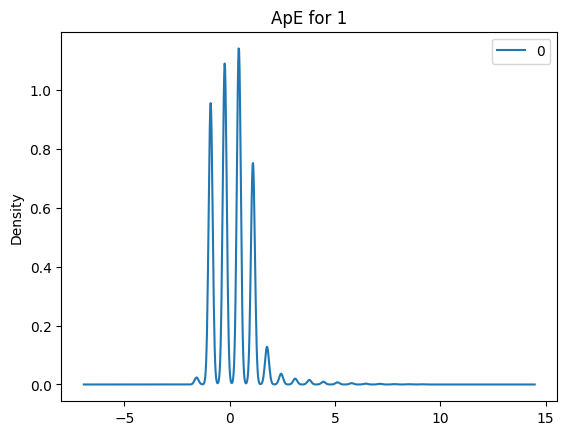

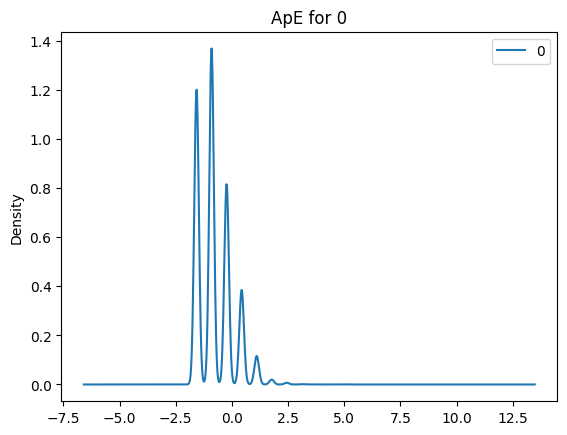

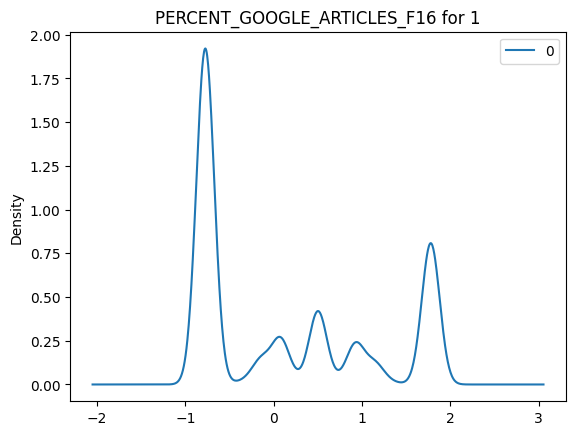

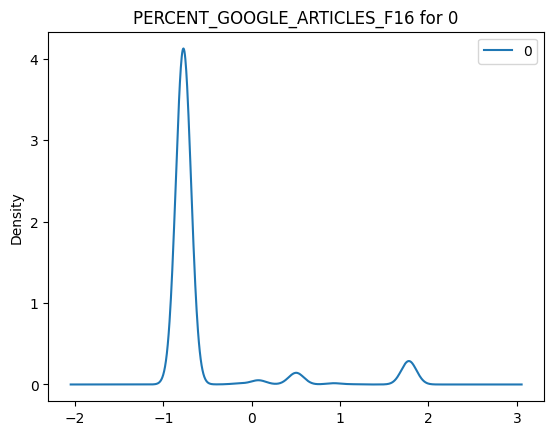

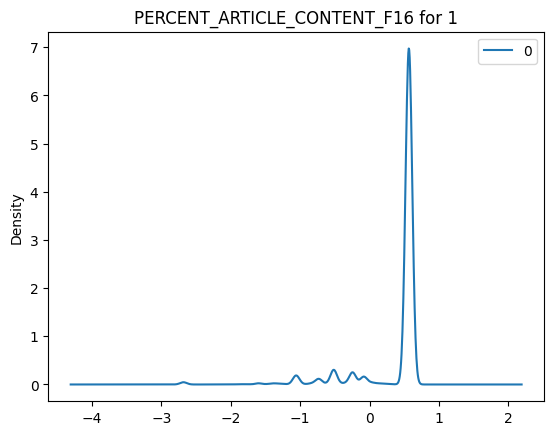

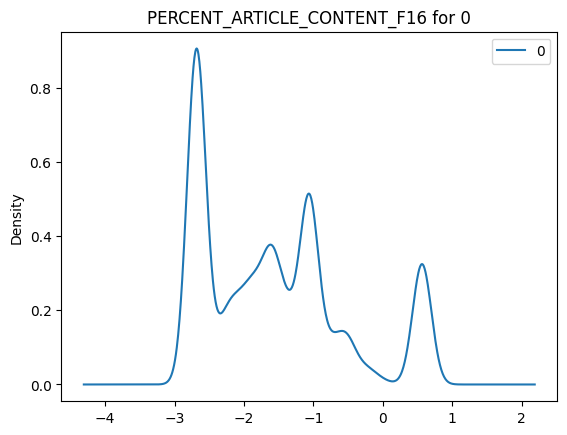

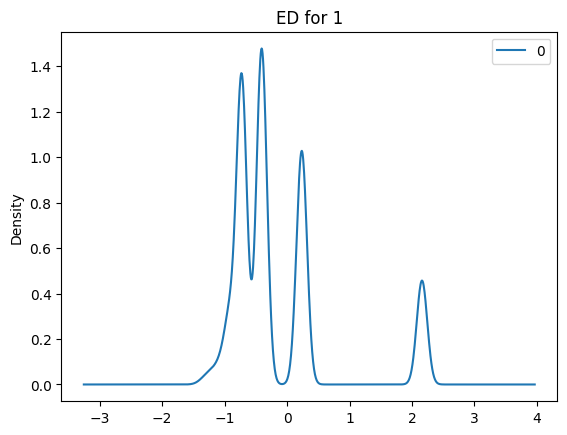

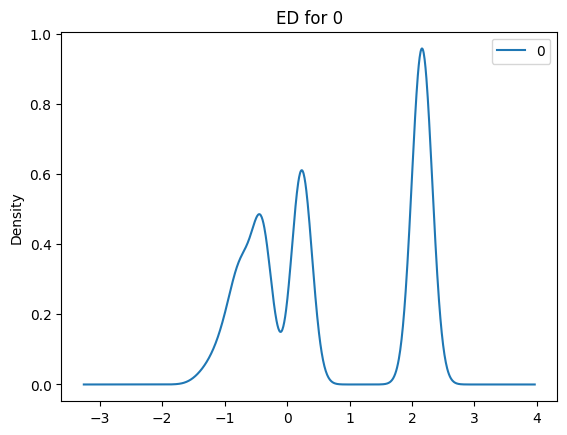

In [9]:
# loop through each feature
for i in range(data.shape[1]):
  # plot the class conditional density
  pd.DataFrame(data[labels == 1,i]).plot.kde(title = f'{features[i]} for 1')
  pd.DataFrame(data[labels == 0,i]).plot.kde(title = f'{features[i]} for 0')
  # print the class conditional mean
  print(data[labels == 1,i].mean())
  print(data[labels == 0,i].mean())
  print()

In [10]:
from sklearn.model_selection import train_test_split

# perform training-validation split on the data
X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.2, random_state=82113)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(105884, 4) (26472, 4) (105884,) (26472,)


In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt

# define the weight initializer
init = tf.keras.initializers.GlorotNormal()

# define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_dim=data.shape[1], activation='relu', kernel_initializer=init),
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer=init),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init)
])

# compile the model using the appropriate loss function and optimizer
model.compile(
    loss='binary_crossentropy', 
    optimizer="adam", 
    metrics=['accuracy']
)

# define a training function
def plot_training(model, num_epochs = 25):
  history = model.fit(
    X_train, y_train,
    verbose=0, 
    epochs=num_epochs, 
    batch_size=32,
    validation_data = (X_valid, y_valid),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, 
                                                verbose=0, restore_best_weights=True)]
  )

  _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
  _, test_accuracy = model.evaluate(X_valid, y_valid, verbose=0)
  print('Train: %.2f, Test: %.2f' % (train_accuracy, test_accuracy))

  # plot the training performance metrics
  plt.plot(history.history['accuracy'], label='train_accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Train: 0.94, Test: 0.94


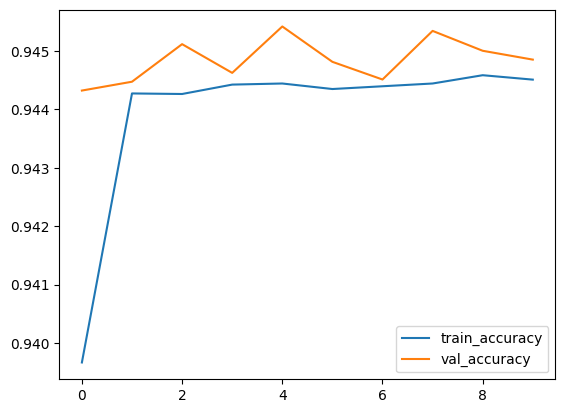

In [14]:
# train the model
plot_training(model, num_epochs=10)

In [15]:
# proportion of training data labeled as 1
sum(y_train)/len(y_train)

0.8054852480072532

In [16]:
# compute test prediction scores
val_predicts = model.predict(X_valid)

828/828 [==============================] - 1s 1ms/step


0.9624555631123385

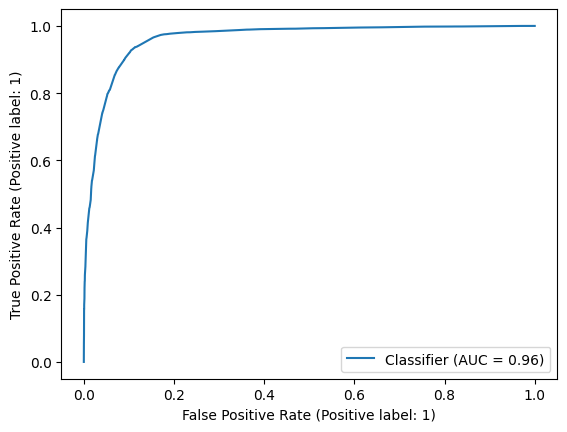

In [17]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

# plot the ROC curve
RocCurveDisplay.from_predictions(y_valid, val_predicts)

# compute AUROC
roc_auc_score(y_valid, val_predicts)

In [18]:
from sklearn.metrics import roc_curve

# find the optimal threshold
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])[0]

threshold = Find_Optimal_Cutoff(y_valid, val_predicts)
threshold

0.8856421709060669

[[ 4629   469]
 [ 2032 19342]]


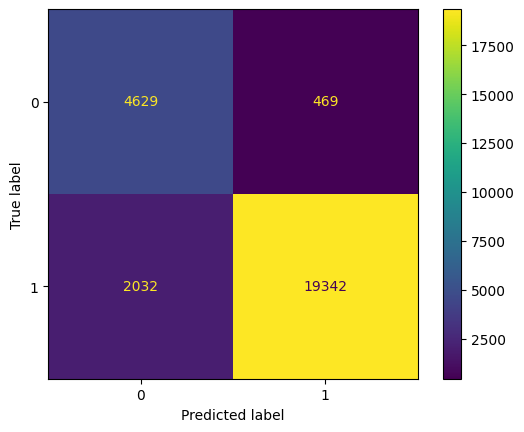

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# produce confusion matrix
y_pred = 1*(val_predicts >= threshold)
cm = confusion_matrix(y_valid, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

In [20]:
print('True Postive Rate:', cm[1][1]/(cm[1][1]+cm[1][0]))
print('True Negative Rate:', cm[0][0]/(cm[0][0]+cm[0][1]))

print('False Postive Rate:', cm[0][1]/(cm[0][0]+cm[0][1]))
print('False Negative Rate:', cm[1][0]/(cm[1][1]+cm[1][0]))

True Postive Rate: 0.9049312248526247
True Negative Rate: 0.9080031384856807
False Postive Rate: 0.09199686151431934
False Negative Rate: 0.09506877514737531


In [ ]:
# add threshold table